## Lasso and Ridge

In [1]:
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import AbsorbingLS
from linearmodels import PanelOLS
import warnings
from linearmodels.iv.absorbing import AbsorbingEffectWarning
import psutil
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

In [3]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [4]:
# Step 8: Define the function to run regressions
def run_regression(df, outcome_var, edum_vars, control_vars):
    # Ensure the dataframe is indexed properly with MultiIndex for fixed effects
    df_regression = df.copy()
    
    # Combining edum* and control variables
    df2 = df_regression[[outcome_var] + edum_vars + control_vars + ['clustID']].dropna()
    X = df2[edum_vars + control_vars]
    y = df2[outcome_var]

    # Absorbing fixed effects (indivID and group_timeID) and clustering by clustID
    model = AbsorbingLS(y, X,  drop_absorbed=True).fit(cov_type='clustered', clusters=df2['clustID'])

    return model

In [5]:
df = pd.read_csv("./Final Data/analysis_input.csv")
df['principal_city_binary'] = df['principal_city'] = np.where(df['principal_city'] == 999999, np.nan, np.where(df['principal_city'] == 0, 0, 1))
df['urban_rural_binary'] = np.where(df['urbanrural'].isin(['M', 'U']), 1, np.where(df['urbanrural'] == 'R', 0, np.nan))
# Merger Sample
df = df.dropna(subset=['overlap'])

### DID Trend analysis and Reduced form Regressions

In [6]:
df = df[df['mergerID'] != 9]

In [7]:
# Step 2: Event Year
df['event_year'] = df['year'] - df['EFFDATE']

# Step 3: Generate event-year dummies
df['T < -5'] = (df['event_year'] < -5) & (df['overlap'] == 1).astype(int)
df['T = -5'] = (df['event_year'] == -5) & (df['overlap'] == 1).astype(int)
df['T = -4'] = (df['event_year'] == -4) & (df['overlap'] == 1).astype(int)
df['T = -3'] = (df['event_year'] == -3) & (df['overlap'] == 1).astype(int)
df['T = -2'] = (df['event_year'] == -2) & (df['overlap'] == 1).astype(int)
#df['edum_n1'] = (df['event_year'] == -1) & (df['overlap'] == 1).astype(int)
df['T = 0'] = (df['event_year'] == 0) & (df['overlap'] == 1).astype(int)
df['T = 1'] = (df['event_year'] == 1) & (df['overlap'] == 1).astype(int)
df['T = 2'] = (df['event_year'] == 2) & (df['overlap'] == 1).astype(int)
df['T = 3'] = (df['event_year'] == 3) & (df['overlap'] == 1).astype(int)
df['T = 4'] = (df['event_year'] == 4) & (df['overlap'] == 1).astype(int)
df['T = 5'] = (df['event_year'] == 5) & (df['overlap'] == 1).astype(int)
df['T >= 5'] = (df['event_year'] > 5) & (df['overlap'] == 1).astype(int)

# Step 4: Generate year dummies (ydum1999 to ydum2013)
for year in range(2010, 2023):
    df[f'ydum{year}'] = (df['year'] == year).astype(int)
    
# Step 5: Interact control variables with year dummies 
control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']

# Step 7: Create group variables
#df['mergerID'] = pd.factorize(df['mergerID'])[0]
df['group_timeID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'year']].apply(tuple, axis=1))[0])
df['indivID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'tract']].apply(tuple, axis=1))[0])
df['clustID'] = pd.Categorical(pd.factorize(df[['state', 'county']].apply(tuple, axis=1))[0])

edum_vars = [col for col in df.columns if col.startswith('T')]

# List of variables to demean (dependent variable, endogenous variable, exogenous variables)
vars_to_demean = ['total_branches_tract', 'branch_closures_tract', 'sbl_total', 'vol_sbus', 'sbl_total_num', 'num_sbus'] + edum_vars + control_vars

In [8]:
# Demean the dataset by indivID and group_timeID
df_demeaned = demean(df, 'indivID', vars_to_demean)

df_final = demean(df_demeaned, 'group_timeID', vars_to_demean) #[var for var in vars_to_demean if var not in ['total_branches_county', 'avg_branch_growth_county']]

# Suppress AbsorbingEffectWarning specifically
warnings.filterwarnings("ignore", category=AbsorbingEffectWarning)

# Step 9: Run regressions for num_closings
model1 = run_regression(df_final, 'branch_closures_tract', edum_vars, control_vars)
model2 = run_regression(df_final, 'total_branches_tract', edum_vars, control_vars)
model3 = run_regression(df_final, 'vol_sbus', edum_vars, control_vars) # sbl_total vol_100k vol_250k vol_1mil vol_sbus

In [9]:
round(pd.DataFrame({'Clo_Beta':model1.params, 'Clo_pvalues':model1.pvalues, 'Tot_Beta':model2.params, 'Tot_pvalues':model2.pvalues,
                'SBL_Beta':model3.params, 'SBL_pvalues':model3.pvalues}),    3)

,Clo_Beta,Clo_pvalues,Tot_Beta,Tot_pvalues,SBL_Beta,SBL_pvalues
T < -5,0.008,0.788,0.102,0.338,184.316,0.035
T = -5,0.021,0.776,0.029,0.778,-233.835,0.223
T = -4,-0.032,0.404,0.068,0.383,-165.854,0.327
T = -3,-0.059,0.056,0.245,0.002,-134.104,0.283
T = -2,0.011,0.780,0.208,0.001,73.812,0.395
T = 0,0.058,0.287,0.080,0.381,-103.118,0.612
T = 1,0.303,0.000,-0.337,0.000,-194.266,0.046
T = 2,-0.017,0.725,-0.401,0.000,488.881,0.392
T = 3,-0.011,0.891,-0.401,0.002,156.582,0.318
T = 4,0.010,0.756,-0.379,0.001,377.679,0.166


In [10]:
df_1 = df_final[['branch_closures_tract'] + edum_vars + control_vars + ['clustID']].dropna()
df_2 = df_final[['total_branches_tract'] + edum_vars + control_vars + ['clustID']].dropna()
df_3 = df_final[['sbl_total'] + edum_vars + control_vars + ['clustID']].dropna()

In [11]:
df_final = df_final.dropna(subset = ['branch_closures_tract', 'total_branches_tract', 'sbl_total'] + edum_vars + control_vars + ['clustID'])

In [12]:
df_X = df_final[edum_vars+control_vars]

### Lasso Plot

In [19]:
def lasso_plot(X_df, Y_df, y_name):
    # Centering the data by subtracting the mean
    Xs = X_df - X_df.mean(axis=0)

    # Scaling the data by dividing by the standard deviation
    X_scale = X_df.std(axis=0)
    Xs = Xs / X_scale

    Y = Y_df[y_name]

    lambdas, soln_array = skl.Lasso.path(Xs,
                                        Y,
                                        l1_ratio=1,
                                        n_alphas=100)[:2]
    soln_path = pd.DataFrame(soln_array.T,
                            columns=Xs.columns,
                            index=-np.log(lambdas))

    # Set up a colormap
    colors = cm.get_cmap('tab20', len(soln_path.columns))  # Adjust 'tab20' or use other colormaps like 'viridis', 'plasma'

    # Create a new figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each line with a unique color
    for i, column in enumerate(soln_path.columns[0:12]):
        soln_path[column].plot(ax=ax, color=colors(i), label=column)

    # Add the legend with multiple columns
    ax.legend(loc='upper left', ncol=5)

    # Set labels with LaTeX formatting
    ax.set_xlabel(r'$-\log(\lambda)$', fontsize=20)
    ax.set_ylabel('Standardized coefficients', fontsize=20)

    plt.show()

C:\Users\yulon\AppData\Local\Temp\ipykernel_43464\1700740994.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(soln_path.columns))  # Adjust 'tab20' or use other colormaps like 'viridis', 'plasma'


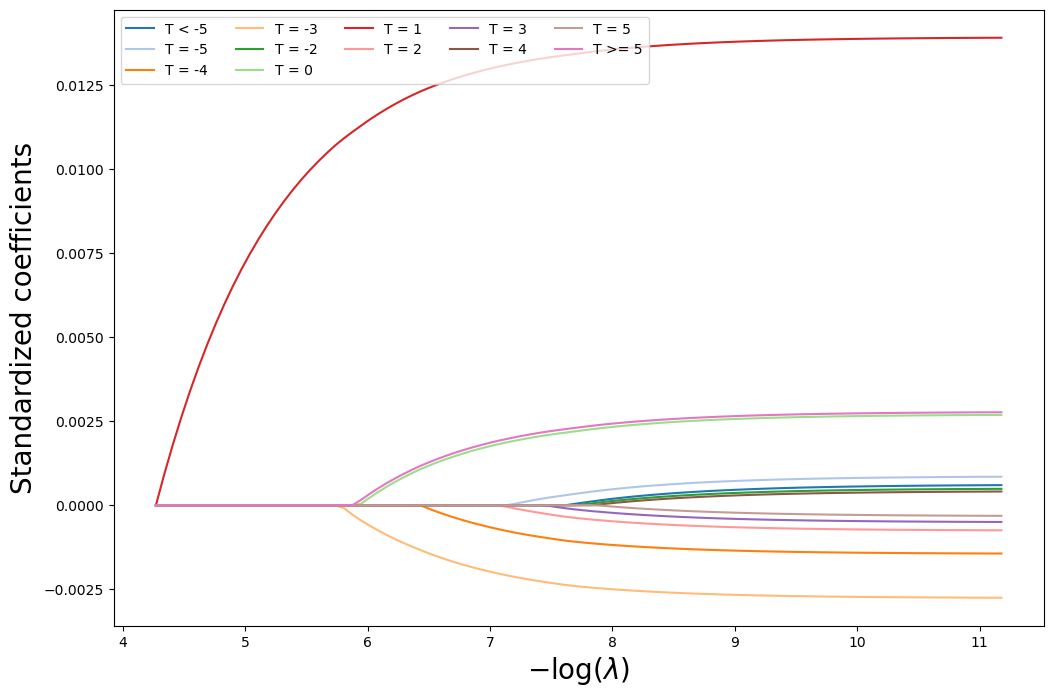

In [20]:
lasso_plot(df_X, df_final, 'branch_closures_tract')

C:\Users\yulon\AppData\Local\Temp\ipykernel_43464\1700740994.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(soln_path.columns))  # Adjust 'tab20' or use other colormaps like 'viridis', 'plasma'


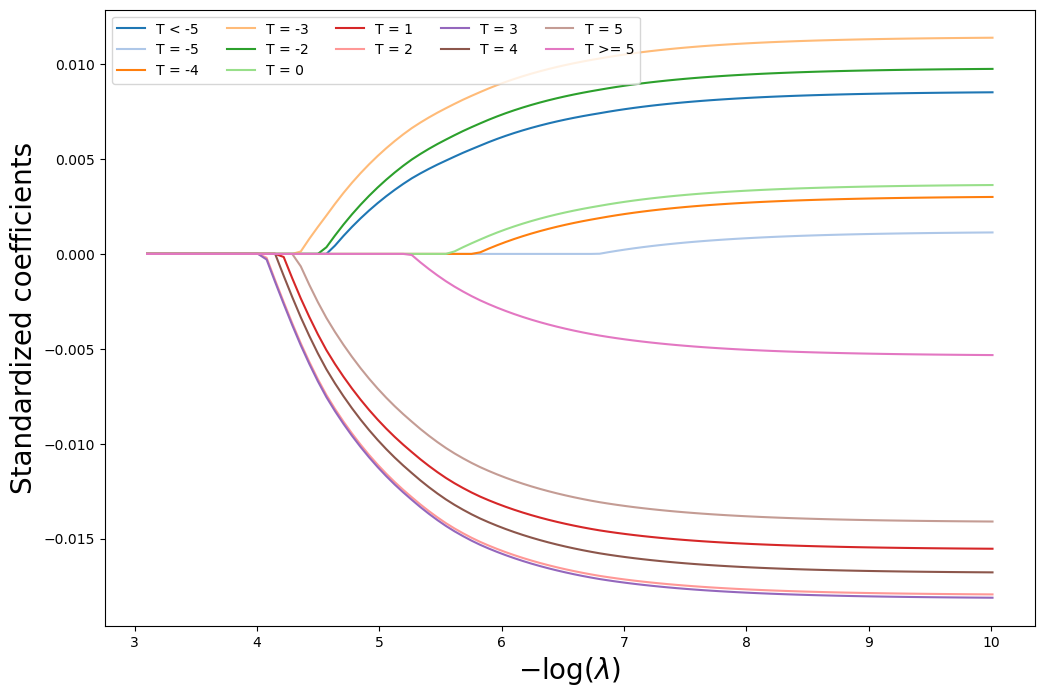

In [21]:
lasso_plot(df_X, df_final, 'total_branches_tract')

C:\Users\yulon\AppData\Local\Temp\ipykernel_43464\1700740994.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(soln_path.columns))  # Adjust 'tab20' or use other colormaps like 'viridis', 'plasma'


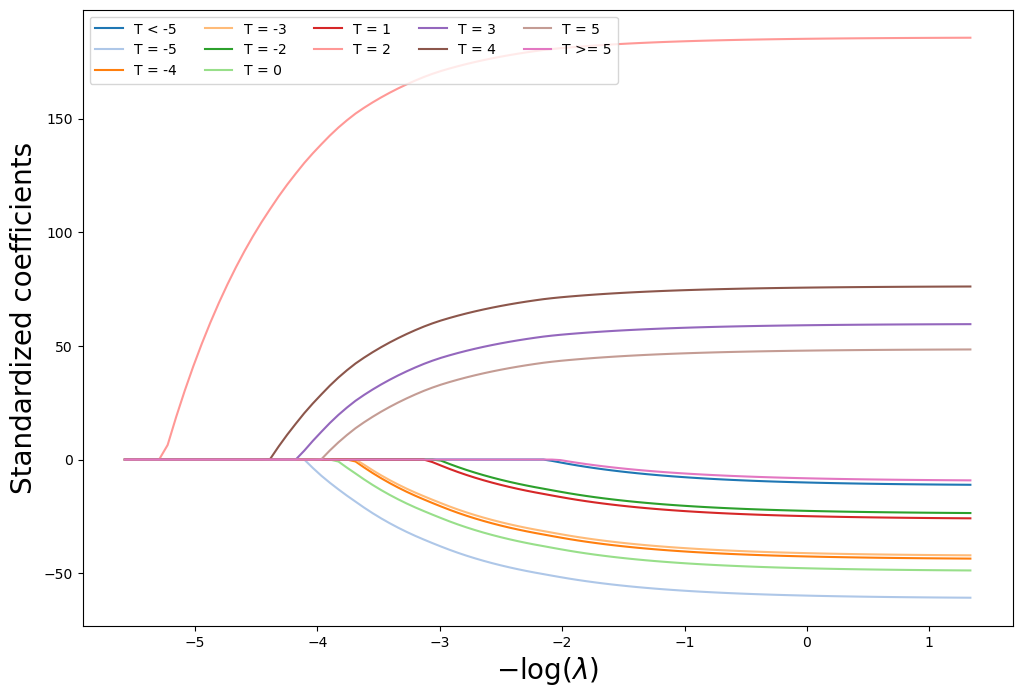

In [22]:
lasso_plot(df_X, df_final, 'sbl_total')

### Lasso with Bootstrap

In [ ]:
def lasso_bootstrap(df, Y, n_iterations, size, K):
    coefficients = {}
    n_size = int(len(df) * size)
    scaler = StandardScaler(with_mean=True,  with_std=True)

    for i in range(n_iterations):
        # Bootstrap resample
        X_resampled, y_resampled = resample(df, Y, n_samples=n_size)
        
        kfold = skm.KFold(K,
                        random_state=0,
                        shuffle=True)
        
        lassoCV = skl.ElasticNetCV(n_alphas=100,
                            l1_ratio=1,
                            cv=kfold)
        
        pipeCV = Pipeline(steps=[('scaler', scaler),
                                ('lasso', lassoCV)])
        pipeCV.fit(X_resampled, y_resampled)
        tuned_lasso = pipeCV.named_steps['lasso']

        # Store the coefficients
        coefficients[f'sample_{i}'] = tuned_lasso.coef_

    # Create a DataFrame to see the results
    coef_summary = pd.DataFrame(coefficients)

    boot_mean = coef_summary.apply('mean', axis = 1)
    boot_std = coef_summary.apply('std', axis = 1)

    output_df = pd.DataFrame({'Features':df.columns, 'Bootstrapped Coef':boot_mean, 'Bootstrapped Std':boot_std})
    
    return output_df

In [13]:
result_closure = lasso_bootstrap(df_X, df_final['branch_closures_tract'], n_iterations = 1000, size = 0.8, K = 5)
result_branch_total = lasso_bootstrap(df_X, df_final['total_branches_tract'], n_iterations = 1000, size = 0.8, K = 5)
result_sbl = lasso_bootstrap(df_X, df_final['sbl_total'], n_iterations = 1000, size = 0.8, K = 5)

In [14]:
result_closure

,Features,Bootstrapped Coef,Bootstrapped Std
0,edum_lessm5,-0.000601,0.002457
1,edum_n5,-0.001582,0.002270
2,edum_n4,-0.002211,0.001882
3,edum_n3,-0.003576,0.002335
4,edum_n2,0.000732,0.001422
5,edum_0,-0.000740,0.001635
6,edum_1,0.008627,0.003885
7,edum_2,-0.000128,0.001165
8,edum_3,0.001086,0.002724
9,edum_4,0.000026,0.000651


In [15]:
result_branch_total

,Features,Bootstrapped Coef,Bootstrapped Std
0,edum_lessm5,0.000744,0.006060
1,edum_n5,0.012552,0.004734
2,edum_n4,0.014183,0.004129
3,edum_n3,0.026536,0.004849
4,edum_n2,0.017957,0.003585
5,edum_0,0.014696,0.004465
6,edum_1,-0.007934,0.004389
7,edum_2,-0.015439,0.004488
8,edum_3,-0.018430,0.006430
9,edum_4,-0.018890,0.007258


In [16]:
result_sbl

,Features,Bootstrapped Coef,Bootstrapped Std
0,edum_lessm5,-185.496013,63.143880
1,edum_n5,-182.166151,84.324609
2,edum_n4,-100.275448,52.402601
3,edum_n3,-111.515946,48.549592
4,edum_n2,-27.203459,32.834194
5,edum_0,-81.711278,37.334484
6,edum_1,-58.467109,39.311772
7,edum_2,555.616716,268.471662
8,edum_3,180.786526,94.880145
9,edum_4,87.974213,70.004196
